<a href="https://colab.research.google.com/github/bethuunltd/Cyclone_Tracking/blob/main/Cyclone_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
WINDOW_LEN   = 5        # how many past fixes you feed in (inclusive)
PATCH_CH     = 4        # ERA5 fields per step (matches 25×25×4 = 2500)
PATCH_H = PATCH_W = 25  # spatial size after you reshaped from 2500
HIDDEN_UNITS = 256      # LSTM hidden size
BATCH_SIZE   = 32
EPOCHS       = 40


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [4]:
# ---------------------------------------
# Load flat patches & metadata (unchanged)
# ---------------------------------------
features = np.load("cyclone_features_filtered.npy").astype(np.float32)   # (N,2500)
df       = pd.read_csv("combined_13_filtered.csv", parse_dates=["Datetime"])
assert len(features) == len(df)

# ---------------------------------------
# Build windowed samples
# ---------------------------------------
X_patch_seq, X_coord_seq, y_next_coord, seq_lens = [], [], [], []

for _, g in df.groupby("Unique_ID"):
    g = g.sort_values("Datetime")
    idxs = g.index.to_list()
    if len(idxs) < 2:
        continue

    for t in range(1, len(idxs)):               # predict point t from 0…t‑1
        start  = max(0, t - WINDOW_LEN)
        window = idxs[start:t]                  # variable length (≤ WINDOW_LEN)

        # ---- ERA5 patches ----
        patch_stack = features[window].reshape(-1, PATCH_CH, PATCH_H, PATCH_W)  # (L,4,25,25)
        pad_len = WINDOW_LEN - patch_stack.shape[0]
        if pad_len:
            pad_patches = np.zeros((pad_len, PATCH_CH, PATCH_H, PATCH_W), np.float32)
            patch_stack = np.vstack([pad_patches, patch_stack])                # front‑pad

        # ---- coords ----
        coord_stack = g.loc[window, ["Latitude","Longitude"]].to_numpy(dtype=np.float32)
        if pad_len:
            coord_stack = np.vstack([np.zeros((pad_len,2), np.float32), coord_stack])

        # ---- target ----
        next_coord = g.loc[idxs[t], ["Latitude","Longitude"]].to_numpy(dtype=np.float32)

        # collect
        X_patch_seq.append(patch_stack)
        X_coord_seq.append(coord_stack)
        y_next_coord.append(next_coord)
        seq_lens.append(len(window))            # real length (≤ WINDOW_LEN)

# to numpy
X_patch_seq  = np.stack(X_patch_seq)            # (M, WINDOW_LEN, 4,25,25)
X_coord_seq  = np.stack(X_coord_seq)            # (M, WINDOW_LEN, 2)
y_next_coord = np.stack(y_next_coord)           # (M, 2)
seq_lens     = np.array(seq_lens, np.int16)     # (M,)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler_coord = MinMaxScaler(feature_range=(-1,1))       # LSTM likes centred data

flat_coords = np.vstack([X_coord_seq.reshape(-1,2), y_next_coord])
scaler_coord.fit(flat_coords)

X_coord_seq_scaled  = scaler_coord.transform(X_coord_seq.reshape(-1,2)).reshape(*X_coord_seq.shape)
y_next_coord_scaled = scaler_coord.transform(y_next_coord)


In [6]:
class CycloneSeqDataset(Dataset):
    def __init__(self, patches, coords, targets, lengths):
        self.patches  = torch.tensor(patches,  dtype=torch.float32)
        self.coords   = torch.tensor(coords,   dtype=torch.float32)
        self.targets  = torch.tensor(targets, dtype=torch.float32)
        self.lengths  = torch.tensor(lengths, dtype=torch.int16)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (self.patches[idx],
                self.coords[idx],
                self.targets[idx],
                self.lengths[idx])

dataset = CycloneSeqDataset(X_patch_seq,
                            X_coord_seq_scaled,
                            y_next_coord_scaled,
                            seq_lens)

# 70/15/15 split
N = len(dataset)
train_N, val_N = int(0.7*N), int(0.15*N)
test_N = N - train_N - val_N
train_set, val_set, test_set = random_split(dataset, [train_N, val_N, test_N])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE)


In [7]:
class CNNBackbone(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(PATCH_CH, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)                     # → (B,128,1,1)
        )

    def forward(self, x):                               # (B,T,4,25,25)
        B, T = x.shape[:2]
        x = x.view(B*T, PATCH_CH, PATCH_H, PATCH_W)     # merge time
        feat = self.net(x).flatten(1)                   # (B*T,128)
        return feat.view(B, T, -1)                      # (B,T,128)

class TrackLSTM(nn.Module):
    def __init__(self, hidden=HIDDEN_UNITS, bidir=BIDIR):
        super().__init__()
        self.cnn  = CNNBackbone()
        self.lstm = nn.LSTM(
            input_size=128 + 2,     # CNN feat + (lat,lon)
            hidden_size=hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=bidir,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden * (2 if bidir else 1), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, patches, coords, lengths):
        x = self.cnn(patches)                      # (B,T,128)
        x = torch.cat([x, coords], dim=-1)         # (B,T,130)

        # pack for speed / ignore padded steps
        x = nn.utils.rnn.pack_padded_sequence(
                x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        _, (h_n, _) = self.lstm(x)                 # h_n: (1 or 2, B, H)

        if self.lstm.bidirectional:
            h_n = torch.cat([h_n[-2], h_n[-1]], dim=1)  # (B,2H)
        else:
            h_n = h_n[-1]                               # (B,H)

        return self.head(h_n)                     # (B,2)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = TrackLSTM().to(device)
criterion  = nn.MSELoss()
optimizer  = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                  factor=0.5, patience=2)

best_val = float("inf")
SAVE_PATH = "best_seq_tracker.pt"

for epoch in range(EPOCHS):
    # ---- train ----
    model.train()
    tr_loss = 0.0
    for p_seq, c_seq, tgt, lens in train_loader:
        p_seq, c_seq, tgt, lens = (p_seq.to(device), c_seq.to(device),
                                   tgt.to(device),  lens.to(device))
        optimizer.zero_grad()
        pred = model(p_seq, c_seq, lens)
        loss = criterion(pred, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        tr_loss += loss.item()
    tr_loss /= len(train_loader)

    # ---- val ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for p_seq, c_seq, tgt, lens in val_loader:
            p_seq, c_seq, tgt, lens = (p_seq.to(device), c_seq.to(device),
                                       tgt.to(device), lens.to(device))
            pred = model(p_seq, c_seq, lens)
            val_loss += criterion(pred, tgt).item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"✅  Epoch {epoch+1}: new best val {val_loss:.4f}")

    print(f"Epoch {epoch+1:02d} | train {tr_loss:.4f} | val {val_loss:.4f}")


✅  Epoch 1: new best val 0.0306
Epoch 01 | train 0.0583 | val 0.0306
✅  Epoch 2: new best val 0.0255
Epoch 02 | train 0.0314 | val 0.0255
✅  Epoch 3: new best val 0.0249
Epoch 03 | train 0.0308 | val 0.0249
✅  Epoch 4: new best val 0.0198
Epoch 04 | train 0.0227 | val 0.0198
✅  Epoch 5: new best val 0.0138
Epoch 05 | train 0.0224 | val 0.0138
✅  Epoch 6: new best val 0.0112
Epoch 06 | train 0.0147 | val 0.0112
✅  Epoch 7: new best val 0.0094
Epoch 07 | train 0.0138 | val 0.0094
✅  Epoch 8: new best val 0.0085
Epoch 08 | train 0.0119 | val 0.0085
Epoch 09 | train 0.0099 | val 0.0092
✅  Epoch 10: new best val 0.0084
Epoch 10 | train 0.0106 | val 0.0084
✅  Epoch 11: new best val 0.0069
Epoch 11 | train 0.0118 | val 0.0069
Epoch 12 | train 0.0099 | val 0.0091
Epoch 13 | train 0.0086 | val 0.0078
✅  Epoch 14: new best val 0.0067
Epoch 14 | train 0.0095 | val 0.0067
✅  Epoch 15: new best val 0.0062
Epoch 15 | train 0.0091 | val 0.0062
Epoch 16 | train 0.0081 | val 0.0063
Epoch 17 | train 0.0

In [9]:
for epoch in range(EPOCHS):
    # ---- training loop/epoch ----
    model.train()
    tr_loss = 0.0
    for p_seq, c_seq, tgt, lens in train_loader:
        p_seq, c_seq, tgt, lens = (p_seq.to(device), c_seq.to(device),
                                   tgt.to(device),  lens.to(device))
        optimizer.zero_grad()
        pred = model(p_seq, c_seq, lens)
        loss = criterion(pred, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        tr_loss += loss.item()
    tr_loss /= len(train_loader)

    # ---- validation loop/epoch ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for p_seq, c_seq, tgt, lens in val_loader:
            p_seq, c_seq, tgt, lens = (p_seq.to(device), c_seq.to(device),
                                       tgt.to(device), lens.to(device))
            pred = model(p_seq, c_seq, lens)
            val_loss += criterion(pred, tgt).item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"✅  Epoch {epoch+1}: new best val {val_loss:.4f}")

    print(f"Epoch {epoch+1:02d} | train {tr_loss:.4f} | val {val_loss:.4f}")


Epoch 01 | train 0.0047 | val 0.0043
Epoch 02 | train 0.0048 | val 0.0043
Epoch 03 | train 0.0051 | val 0.0045
Epoch 04 | train 0.0052 | val 0.0043
Epoch 05 | train 0.0048 | val 0.0046
Epoch 06 | train 0.0050 | val 0.0043
✅  Epoch 7: new best val 0.0042
Epoch 07 | train 0.0049 | val 0.0042
Epoch 08 | train 0.0047 | val 0.0042
Epoch 09 | train 0.0049 | val 0.0042
Epoch 10 | train 0.0048 | val 0.0042
Epoch 11 | train 0.0050 | val 0.0042
✅  Epoch 12: new best val 0.0042
Epoch 12 | train 0.0049 | val 0.0042
Epoch 13 | train 0.0045 | val 0.0042
Epoch 14 | train 0.0045 | val 0.0042
Epoch 15 | train 0.0050 | val 0.0042
Epoch 16 | train 0.0048 | val 0.0042
Epoch 17 | train 0.0046 | val 0.0042
Epoch 18 | train 0.0049 | val 0.0042
Epoch 19 | train 0.0048 | val 0.0042
Epoch 20 | train 0.0049 | val 0.0042
Epoch 21 | train 0.0047 | val 0.0042
Epoch 22 | train 0.0049 | val 0.0042
✅  Epoch 23: new best val 0.0042
Epoch 23 | train 0.0045 | val 0.0042
Epoch 24 | train 0.0048 | val 0.0042
Epoch 25 | tra

In [10]:
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

preds, trues = [], []
with torch.no_grad():
    for p_seq, c_seq, tgt, lens in test_loader:
        p_seq, c_seq = p_seq.to(device), c_seq.to(device)
        out = model(p_seq, c_seq, lens.to(device)).cpu().numpy()
        preds.append(out)
        trues.append(tgt.numpy())

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

# back to degrees
pred_deg = scaler_coord.inverse_transform(preds)
true_deg = scaler_coord.inverse_transform(trues)

rmse = np.sqrt(mean_squared_error(true_deg, pred_deg))
mae  = mean_absolute_error(true_deg, pred_deg)
r2   = r2_score(true_deg, pred_deg)
print(f"\nTest RMSE {rmse:.3f} | MAE {mae:.3f} | R² {r2:.3f}")



Test RMSE 3.210 | MAE 1.182 | R² 0.955


In [11]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 91.1 MB/s eta 0:00:00


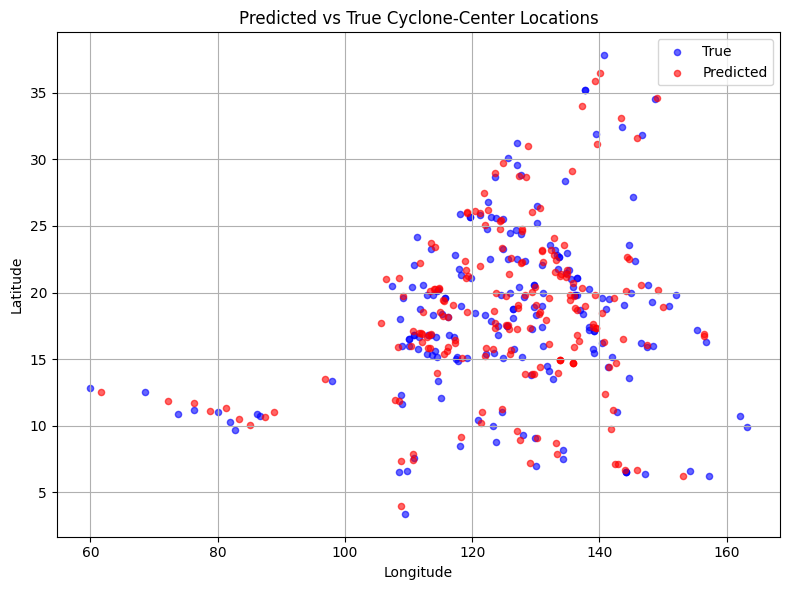

In [12]:
import matplotlib.pyplot as plt

# ── after you have true_deg and pred_deg from the evaluation step ──
plt.figure(figsize=(8, 6))
plt.scatter(true_deg[:, 1],  true_deg[:, 0],
            label='True',      alpha=0.6, s=20, c='blue')
plt.scatter(pred_deg[:, 1],  pred_deg[:, 0],
            label='Predicted', alpha=0.6, s=20, c='red')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predicted vs True Cyclone‐Center Locations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pred_vs_true_scatter.png", dpi=600)
plt.show()


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


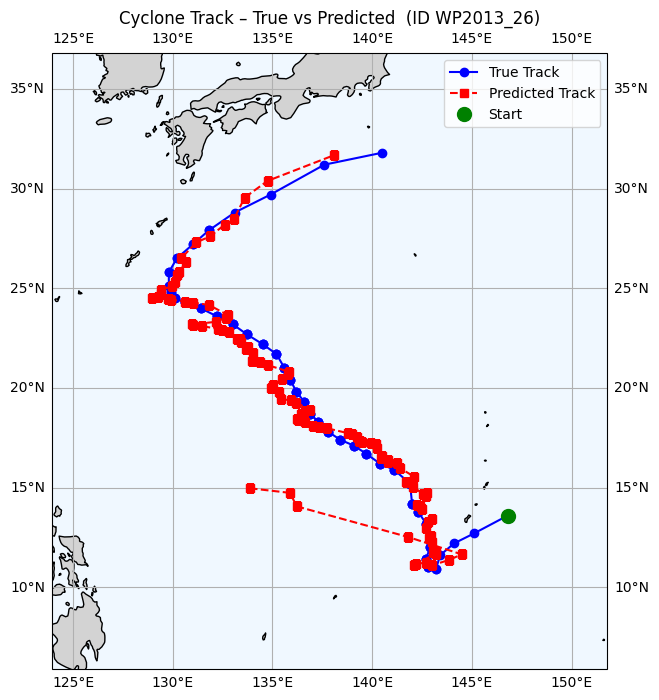

In [13]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

WINDOW_LEN = 5          # same as in training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# ── load raw data ──────────────────────────────────────────────
features = np.load("cyclone_features_filtered.npy").astype(np.float32)
df       = pd.read_csv("combined_13_filtered.csv", parse_dates=["Datetime"])

# pick a cyclone (longest track or choose manually)
selected_id = df['Unique_ID'].value_counts().idxmax()
df_cyc = df[df['Unique_ID'] == selected_id].sort_values("Datetime")
idxs   = df_cyc.index.to_list()
if len(idxs) < 2:
    raise ValueError("Not enough points in this cyclone track.")

# accumulate predictions step-by-step
true_pts, pred_pts = [], []

for t in range(1, len(idxs)):                     # predict idxs[t]
    start   = max(0, t - WINDOW_LEN)
    window  = idxs[start:t]                       # 0…t-1 inclusive
    pad_len = WINDOW_LEN - len(window)

    # ------- build window tensors -------
    patch_stack = features[window].reshape(-1, 4, 25, 25)
    coord_stack = df.loc[window, ['Latitude', 'Longitude']].to_numpy(dtype=np.float32)

    if pad_len:                                   # front-pad with zeros
        patch_pad  = np.zeros((pad_len, 4, 25, 25), dtype=np.float32)
        coord_pad  = np.zeros((pad_len, 2),        dtype=np.float32)
        patch_stack = np.vstack([patch_pad,  patch_stack])
        coord_stack = np.vstack([coord_pad,  coord_stack])

    length = torch.tensor([len(window)], dtype=torch.int16)

    # scale coords
    coord_stack_scaled = scaler_coord.transform(coord_stack)

    # to tensors & device
    patch_t = torch.tensor(patch_stack).unsqueeze(0).to(device)   # (1,T,4,25,25)
    coord_t = torch.tensor(coord_stack_scaled).unsqueeze(0).to(device)

    # ------- predict -------
    with torch.no_grad():
        pred_scaled = model(patch_t, coord_t, length.to(device)).cpu().numpy()

    pred_latlon = scaler_coord.inverse_transform(pred_scaled)[0]  # (2,)

    # store points
    true_latlon = df.loc[idxs[t], ['Latitude','Longitude']].to_numpy()
    true_pts.append(true_latlon)
    pred_pts.append(pred_latlon)

true_pts = np.array(true_pts)        # shape (L,2)  lat,lon
pred_pts = np.array(pred_pts)

# ── plot on a map ──────────────────────────────────────────────
fig = plt.figure(figsize=(10, 8))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND,  facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
ax.gridlines(draw_labels=True)

# tracks
ax.plot(true_pts[:,1], true_pts[:,0], 'o-', color='blue',  label='True Track',
        transform=ccrs.Geodetic())
ax.plot(pred_pts[:,1], pred_pts[:,0], 's--', color='red',  label='Predicted Track',
        transform=ccrs.Geodetic())

# start marker
ax.plot(true_pts[0,1], true_pts[0,0], 'go', markersize=10,
        label='Start', transform=ccrs.Geodetic())

# zoom to storm
margin = 5
min_lat = min(true_pts[:,0].min(), pred_pts[:,0].min()) - margin
max_lat = max(true_pts[:,0].max(), pred_pts[:,0].max()) + margin
min_lon = min(true_pts[:,1].min(), pred_pts[:,1].min()) - margin
max_lon = max(true_pts[:,1].max(), pred_pts[:,1].max()) + margin
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

plt.title(f"Cyclone Track – True vs Predicted  (ID {selected_id})")
plt.legend()
plt.savefig("cyclone_track_map.png", dpi=300, bbox_inches='tight')
plt.show()
